In [1]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

from itertools import product

## Helper functions

In [2]:
def extract_main_contour(image):
    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # adaptive threshold to handle variations in color intensity
    adaptive_thresh = cv2.adaptiveThreshold(blurred, 255,
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY_INV, 11, 2)
    
    # apply morphological operations to clean up image
    kernel = np.ones((15, 15), np.uint8)
    morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    
    # find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # return the largest contour
    return max(contours, key = cv2.contourArea)


# compute shape similarity between two contours
def shape_similarity(contour1, contour2):
    # matchShapes returns distance between shapes, take the inverse for similarity
    return 1/cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0.0)


# build a similarity matrix for all combinations of images
def similarity_matrix(set1, set2, names):
    matrix = np.zeros((len(set1), len(set2)))

    for i, img1 in enumerate(set1):
        img1_contour = extract_main_contour(img1)

        for j, img2 in enumerate(set2):
            img2_contour = extract_main_contour(img2)

            # compute similarity score and fill in matrix
            matrix[i, j] = shape_similarity(img1_contour, img2_contour)

    # visualize the completed similarity matrix
    plt.imshow(matrix, cmap = 'Blues', interpolation = 'nearest')
    plt.colorbar(label = 'Similarity Score')

    plt.xticks([])
    plt.yticks([])

    plt.xlabel(names[0])
    plt.ylabel(names[1])

    plt.show()
    
    return matrix


# match images using the similarity matrix
def match(sim_matrix, row, col):
    matches = []

    # ensure that dim(row) <= dim(col)
    if len(row) > len(col):
        # transpose the matrix
        sim_matrix = sim_matrix.T

        # swap rows and columns
        row, col = col, row
    
    # traverse the rows and find the corresponding image that maximizes similarity
    for i in range(len(row)):
        # similarity score threshold
        if sim_matrix[i].max() > 2:
            matches.append((row[i], col[sim_matrix[i].argmax()]))

    return matches


# visualize matched slices
def show_matches(matches):
    for img1, img2 in matches:
        _, ax = plt.subplots(1, 2)
        
        ax[0].imshow(img1)
        ax[1].imshow(img2)

        plt.show()


# find 3-way matches
def intersect_matches(matches1, matches2):
    intersections = []
    
    for (i1, i2), (j1, j2) in product(matches1, matches2):
        imgs = [i1, j1, i2, j2]

        shapes = map(lambda x: x.shape, imgs)

        if len(set(shapes)) == 3:
            intersected = []

            for img in imgs:
                if all([img.shape != x.shape for x in intersected]):
                    intersected.append(img)
            
            intersections.append(intersected)

    return intersections


# bundle the helper functions
def pipeline(images, names):
    set1 = images[names[0].lower()]
    set2 = images[names[1].lower()]
    
    similarity = similarity_matrix(set1, set2, names)

    matches = match(similarity, set1, set2)

    show_matches(matches)

    return matches

In [3]:
def read(patient):
    images = {}

    for stain in os.listdir(patient):
        images[stain] = [cv2.imread(os.path.join(patient, stain, tissue)) for tissue in os.listdir(os.path.join(patient, stain))]

    return images


def show(stains):
    for imgs in stains:
        _, ax = plt.subplots(1, len(imgs))

        for i, img in enumerate(imgs):
            ax[i].imshow(img)

        plt.show()

## Example 1

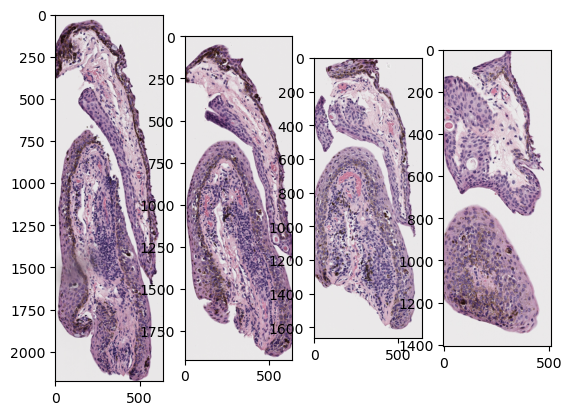

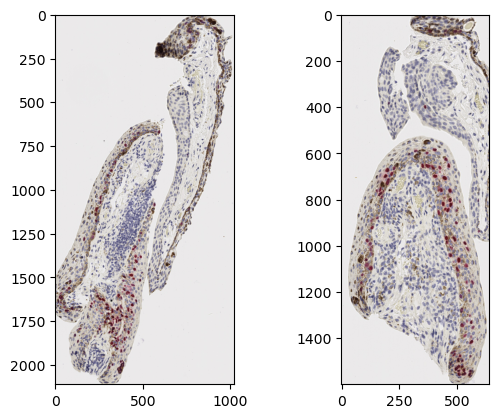

In [4]:
images1 = read('patients/h2114164')

show([images1['h&e'], images1['sox10']])

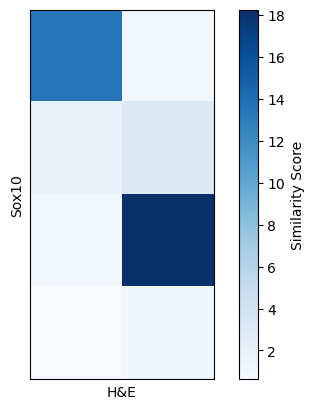

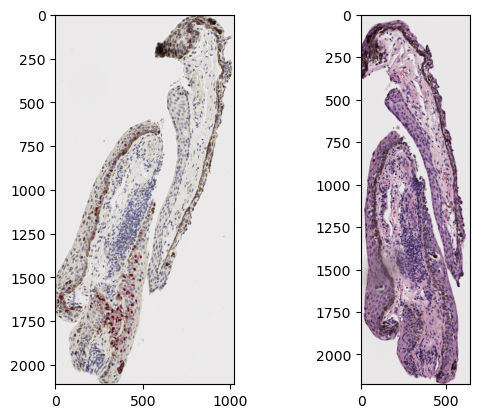

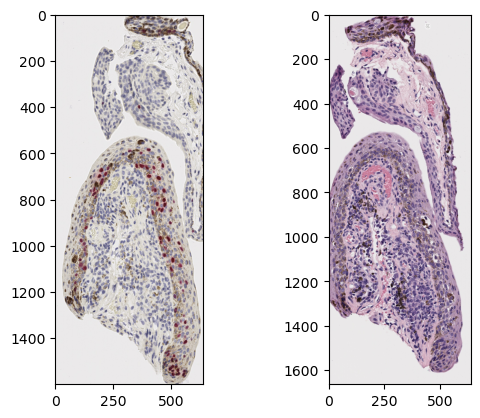

In [5]:
matched = pipeline(images1, ['H&E', 'Sox10'])

## Example 2

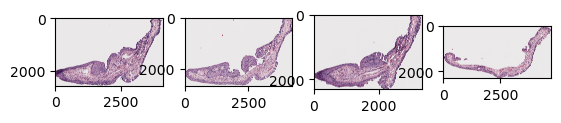

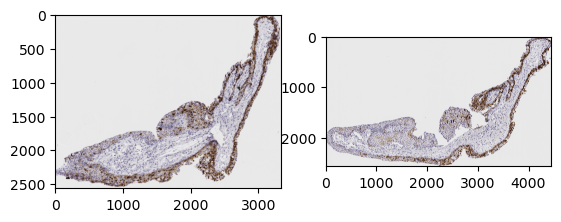

In [6]:
images2 = read('patients/h2114172')

show([images2['h&e'], images2['melan']])

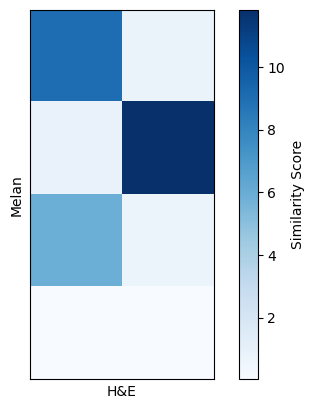

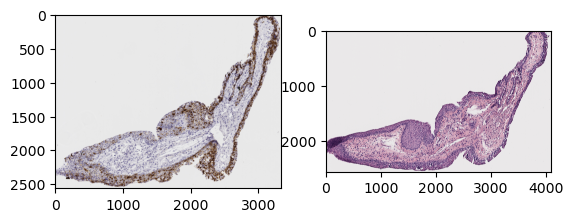

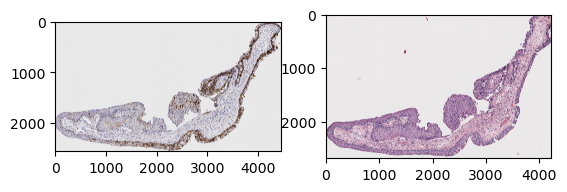

In [7]:
matched = pipeline(images2, ['H&E', 'Melan'])

## Example 3

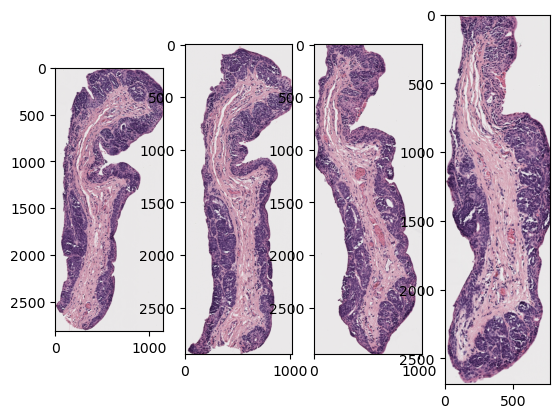

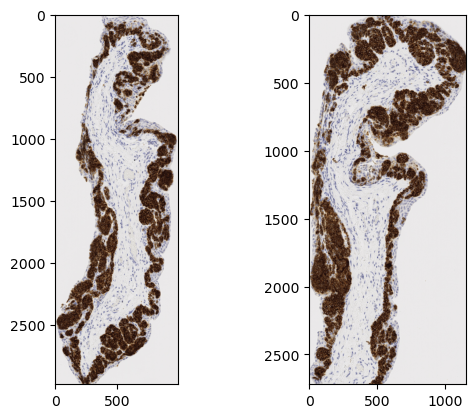

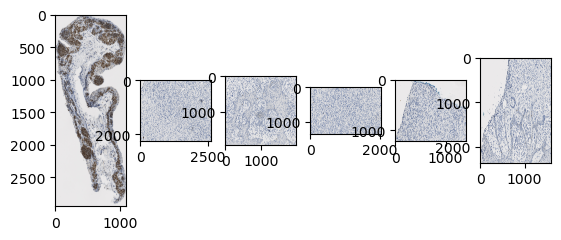

In [8]:
images3 = read('patients/h2114153')

show([images3['h&e'], images3['melan'], images3['sox10']])

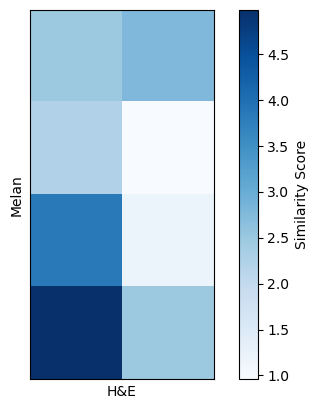

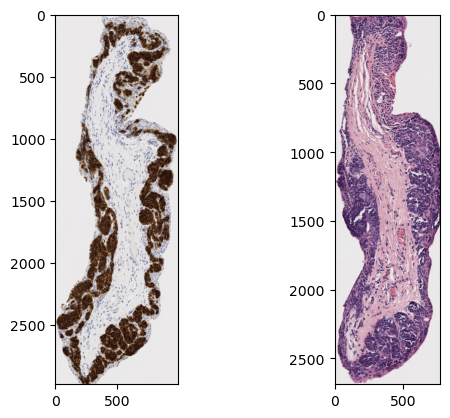

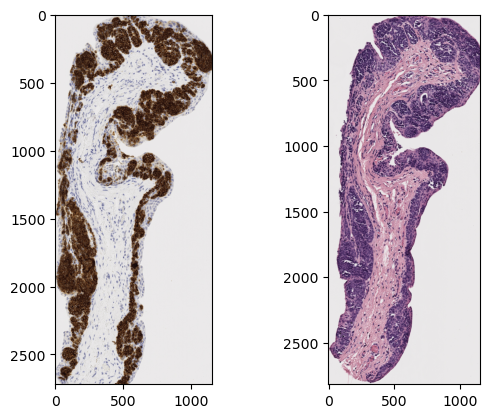

In [9]:
matched1 = pipeline(images3, ['H&E', 'Melan'])

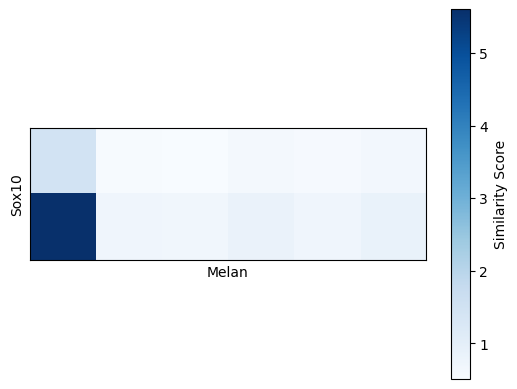

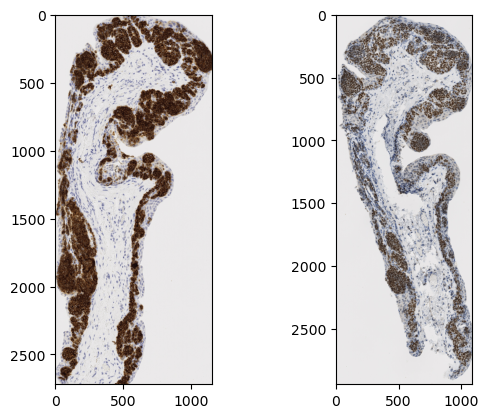

In [10]:
matched2 = pipeline(images3, ['Melan', 'Sox10'])

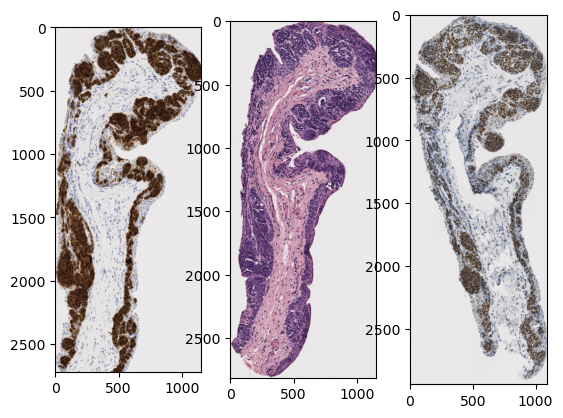

In [11]:
for imgs in intersect_matches(matched1, matched2):
    _, ax = plt.subplots(1, len(imgs))

    for i, img in enumerate(imgs):
        ax[i].imshow(img)

    plt.show()